In [193]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [224]:
# Find the url for 10 pages
base_url="https://www.imdb.com/search/title/?title_type=feature\
&release_date=1930-01-01,2020-12-31\
&countries=us&keywords=based+on+novel\
&languages=en&count=100"

url = base_url+ "&start=" + str(251) + "&ref_=adv_nxt"

url_list=[base_url]
for i in range(101,1301,100):
    url = url+ "&start=" + str(i) + "&ref_=adv_nxt"
    url_list.append(url)

In [225]:
len(url_list)

13

In [226]:
# Create soup_list (13 soup for 13 pages)
def get_soup(url):
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page, "lxml")
    return soup

soup_list=[]
for url in url_list:
    soup_list.append(get_soup(url))

In [227]:
len(soup_list)

13

In [228]:
# Create movie_div_list (1200 movies, 100 movies a page)
movie_div_list=[]
for soup in soup_list:
    for movie in soup.find_all('div',class_="lister-item-content"):
        movie_div_list.append(movie)

In [229]:
len(movie_div_list)

1300

In [230]:
# Define function to get movie data from search result pages
def get_moviedata(movie):
    headers = ['title','link','year','certificate','runtime(min)','genre','rating','vote','gross']
    
    # get movie title, link to movie page
    for link in movie.find_all('a')[0:1]:
        title = link.text
        link = link.get('href')
        
    # get year
    for y in movie.find_all('span', class_="lister-item-year text-muted unbold"):
        year = y.text
        year = int(''.join(i for i in year if i.isdigit()))
    
    # get certifcate, runtime, genre
    for line in movie.find_all('p', class_="text-muted")[0:1]:
        if movie.find_all('span', class_="certificate") == []:
            certificate = np.nan
        else:
            certificate = movie.find('span', class_="certificate").text
        
        if movie.find_all('span', class_="runtime") == []:
            runtime = np.nan
        else:
            runtime = int(movie.find('span', class_="runtime").text.strip(' min'))
        
        if movie.find_all('span', class_="genre") == []:
            genre = np.nan
        else:
            genre = movie.find('span', class_="genre").text.strip('\n').replace(' ','')
        
        
    # get IMDb rating        
    for ratings in movie.find_all('div', class_="ratings-bar"):
        rating =float(ratings.strong.text)
        
    
    # get metascore
        if ratings.find_all('div',class_="metascore favorable") == []:
            meta = np.nan
        else:
            meta=(metascore.text)
            meta=int(''.join(i for i in meta if i.isdigit()))
    
    # get vote, gross
    vote_gross = movie.find_all('span',attrs = {'name':'nv'})
    vote = int(vote_gross[0]['data-value'])
    if len(vote_gross) == 2:
        gross = int(vote_gross[1]['data-value'].replace(',',''))
    else:
        gross = np.nan

    
    # create dictionray for this movie
    movie_dict = dict(zip(headers, [title,
                                link,
                                year,
                                certificate,
                                runtime,
                                genre,
                                rating,
                                vote,
                                gross]))
    
    return movie_dict

In [ ]:
# get detailed data from individual movie webpage
def get_movie_detail(soup):
    
    headers=['movie_title', 'rating', 'vote', 'certificate', 'genre', 'release_date', 'metascore', 'keywords','budget',\
            'opening_weekend_usa','gross_usa','gross_world']
    
    # find movie title
    title = " ".join(soup.find('h1').text.split()[:-1]) ## problem?
    
    # find rating
    rating = float(soup.find('span',attrs={'itemprop':'ratingValue'}).text)
    
    # find vote (rating count)
    vote = int(soup.find('span',attrs={'itemprop':'ratingCount'}).text.replace(',',''))
    
    # find content rating
    certificate = soup.find('div', class_="subtext").text.split()[0]
    
    # find list of genre
    genre_list=[]
    for genres in soup.find('div', class_="subtext").find_all('a')[:-1]:
        genre_list.append(genres.text)
        
    # find release date
    date_list=soup.find('div', class_="subtext").find_all('a')[-1].text.split()
    date_pre = "-".join(date_list[:3])
    date = pd.to_datetime(date_pre, format ='%d-%B-%Y') ## why is it Timestamp?
    
    # find metascorre
    meta = int(soup.find('div',class_="metacriticScore score_favorable titleReviewBarSubItem").text.strip('\n'))
    if meta is None:
        meta = np.nan
        
        
    # find plot keywords
    keyword_list=[]
    for keywords in soup.find('div', class_="article", id="titleStoryLine").\
    find('div', class_="see-more inline canwrap").find_all('a')[:-1]:
        keyword_list.append(keywords.text.strip(' '))
        
        
    # find budget, opening weekend USA, gross USA, cumulative worldwide gross
    for line in soup.find('div', class_="article", id="titleDetails").find_all('h4'):        
        if "Budget:" in line:
            budget = int(''.join(s for s in line.next_sibling if s.isdigit()))
        if "Opening Weekend USA:" in line:
            opening = int(''.join(s for s in line.next_sibling if s.isdigit()))
        if "Gross USA:" in line:
            gross_usa = int(''.join(s for s in line.next_sibling if s.isdigit()))
        if "Cumulative Worldwide Gross:" in line:
            gross_cw = int(''.join(s for s in line.next_sibling if s.isdigit()))
            
    # find runtime
    rt = soup.find('div', class_="article", id="titleDetails").find('time').text
    runtime = int(''.join(s for s in rt if s.isdigit()))
    
    
    movie_dict = dict(zip(headers, [title,
                                    rating,
                                    vote,
                                   certificate,
                                   genre_list,
                                   date,
                                   meta,
                                   keyword_list,
                                   budget,
                                   opening,
                                   gross_usa,
                                   gross_cw]))
    
    return movie_dict

In [231]:
# Create list of dictionaries
movie_data=[]
for movie in movie_div_list:
    movie_data.append(get_moviedata(movie))

In [232]:
len(movie_data),movie_data

(1300,
 [{'title': 'After We Collided',
   'link': '/title/tt10362466/',
   'year': 2020,
   'certificate': 'R',
   'runtime(min)': 105,
   'genre': 'Drama,Romance',
   'rating': 5.0,
   'vote': 16042,
   'gross': nan},
  {'title': 'The Godfather',
   'link': '/title/tt0068646/',
   'year': 1972,
   'certificate': 'R',
   'runtime(min)': 175,
   'genre': 'Crime,Drama',
   'rating': 9.2,
   'vote': 1612607,
   'gross': 134966411},
  {'title': "Harry Potter and the Sorcerer's Stone",
   'link': '/title/tt0241527/',
   'year': 2001,
   'certificate': 'PG',
   'runtime(min)': 152,
   'genre': 'Adventure,Family,Fantasy',
   'rating': 7.6,
   'vote': 653653,
   'gross': 317575550},
  {'title': 'Unknown',
   'link': '/title/tt1401152/',
   'year': 2011,
   'certificate': 'PG-13',
   'runtime(min)': 113,
   'genre': 'Action,Thriller',
   'rating': 6.8,
   'vote': 248285,
   'gross': 63686397},
  {'title': 'The Lord of the Rings: The Fellowship of the Ring',
   'link': '/title/tt0120737/',
   '

In [239]:
movie_df = pd.DataFrame(movie_data)
movie_df.sort_values('rating',ascending=False)

,title,link,year,certificate,runtime(min),genre,rating,vote,gross
1,The Godfather,/title/tt0068646/,1972,R,175,"Crime,Drama",9.2,1612607,134966411.0
31,The Godfather: Part II,/title/tt0071562/,1974,R,202,"Crime,Drama",9.0,1125365,57300000.0
18,The Lord of the Rings: The Return of the King,/title/tt0167260/,2003,PG-13,201,"Action,Adventure,Drama",8.9,1636952,377845905.0
14,Forrest Gump,/title/tt0109830/,1994,PG-13,142,"Drama,Romance",8.8,1800877,330252182.0
4,The Lord of the Rings: The Fellowship of the Ring,/title/tt0120737/,2001,PG-13,178,"Action,Adventure,Drama",8.8,1654691,315544750.0
...,...,...,...,...,...,...,...,...,...
785,Jaws 3-D,/title/tt0085750/,1983,PG,99,"Adventure,Horror,Thriller",3.7,39741,45517055.0
690,Left Behind,/title/tt2467046/,2014,PG-13,110,"Action,Fantasy,Sci-Fi",3.1,37027,13998282.0
1079,The Crow: Wicked Prayer,/title/tt0353324/,2005,R,99,"Action,Adventure,Comedy",3.0,8323,NaN
589,Battlefield Earth,/title/tt0185183/,2000,PG-13,118,"Action,Adventure,Sci-Fi",2.5,75940,21471685.0


In [234]:
movie_df.year.nunique(),np.sort(movie_df.year.unique())

(91,
 array([1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940,
        1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951,
        1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962,
        1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973,
        1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984,
        1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
        1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
        2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
        2018, 2019, 2020]))

(array([3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 3, '3.0'),
  Text(0, 4, '4.0'),
  Text(0, 5, '5.0'),
  Text(0, 6, '6.0'),
  Text(0, 7, '7.0'),
  Text(0, 8, '8.0'),
  Text(0, 9, '9.0')])

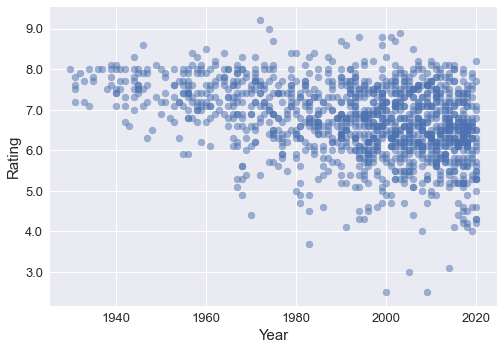

In [235]:
x = movie_df['year']
y = movie_df['rating']
fig, ax = plt.subplots(1,1)
plt.scatter(x,y,alpha=0.5)
ax.set_title('',fontsize=15)
ax.set_xlabel('Year',fontsize=15)
ax.set_ylabel('Rating',fontsize=15)
ax.set_yticks([3,4,5,6,7,8,9])
ax.set_yticklabels(['3.0','4.0','5.0','6.0','7.0','8.0','9.0'])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

(array([3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 3, '3.0'),
  Text(0, 4, '4.0'),
  Text(0, 5, '5.0'),
  Text(0, 6, '6.0'),
  Text(0, 7, '7.0'),
  Text(0, 8, '8.0'),
  Text(0, 9, '9.0')])

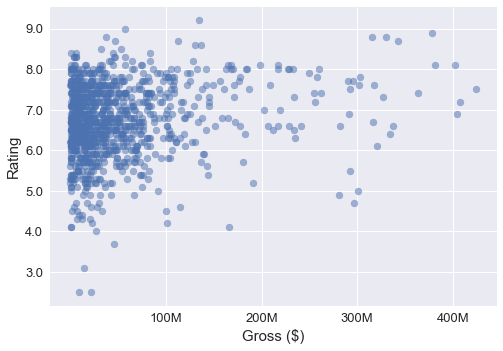

In [236]:
movie_df.dropna(subset=['gross'])
x = movie_df['gross']
y = movie_df['rating']
fig, ax = plt.subplots(1,1)
plt.scatter(x,y,alpha=0.5)
ax.set_title('',fontsize=15)
ax.set_xlabel('Gross ($)',fontsize=15)
ax.set_ylabel('Rating',fontsize=15)
ax.set_xticks([100e6,200e6,300e6,400e6])
ax.set_xticklabels(['100M','200M','300M','400M'])
ax.set_yticks([3,4,5,6,7,8,9])
ax.set_yticklabels(['3.0','4.0','5.0','6.0','7.0','8.0','9.0'])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

(array([3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 3, '3.0'),
  Text(0, 4, '4.0'),
  Text(0, 5, '5.0'),
  Text(0, 6, '6.0'),
  Text(0, 7, '7.0'),
  Text(0, 8, '8.0'),
  Text(0, 9, '9.0')])

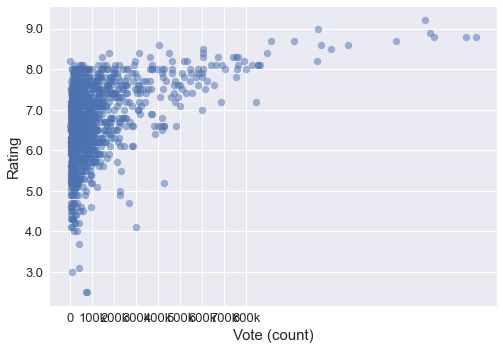

In [237]:
movie_df.dropna(subset=['vote'])
x = movie_df['vote']
y = movie_df['rating']

fig, ax = plt.subplots(1,1)
plt.scatter(x,y,alpha=0.5)
ax.set_title('',fontsize=15)
ax.set_xlabel('Vote (count)',fontsize=15)
ax.set_ylabel('Rating',fontsize=15)
ax.set_xticks([0,100e3,200e3,300e3,400e3,500e3,600e3,700e3,800e3])
ax.set_xticklabels(['0','100k','200k','300k','400k','500k','600k','700k','800k',])
ax.set_yticks([3,4,5,6,7,8,9])
ax.set_yticklabels(['3.0','4.0','5.0','6.0','7.0','8.0','9.0'])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

(array([3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 3, '3.0'),
  Text(0, 4, '4.0'),
  Text(0, 5, '5.0'),
  Text(0, 6, '6.0'),
  Text(0, 7, '7.0'),
  Text(0, 8, '8.0'),
  Text(0, 9, '9.0')])

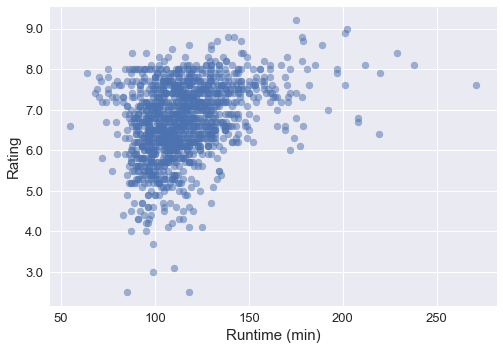

In [238]:
movie_df.dropna(subset=['runtime(min)'])
x = movie_df['runtime(min)']
y = movie_df['rating']

fig, ax = plt.subplots(1,1)
plt.scatter(x,y,alpha=0.5)
ax.set_title('',fontsize=15)
ax.set_xlabel('Runtime (min)',fontsize=15)
ax.set_ylabel('Rating',fontsize=15)

ax.set_yticks([3,4,5,6,7,8,9])
ax.set_yticklabels(['3.0','4.0','5.0','6.0','7.0','8.0','9.0'])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

In [248]:
movie_df[movie_df.title == "The Time Traveler's Wife"]

,title,link,year,certificate,runtime(min),genre,rating,vote,gross
512,The Time Traveler's Wife,/title/tt0452694/,2009,PG-13,107,"Drama,Fantasy,Romance",7.1,140311,63414846.0
